In [0]:
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from pandas_datareader import data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pypfopt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [1]:
#   !pip install PyPortfolioOpt
#   !pip install --upgrade pandas

In [0]:
URL_500 = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
spy_500_stock = list(pd.read_html(URL_500)[0].iloc[1:,0])

URL_400 = 'https://en.wikipedia.org/wiki/List_of_S%26P_400_companies'
spy_400_stock = list(pd.read_html(URL_400)[0].iloc[1:,1])

URL_1000 = 'https://en.wikipedia.org/wiki/List_of_S%26P_1000_companies'
spy_1000_stock = list(pd.read_html(URL_1000)[5].iloc[1:,1])
spy_600_stock = [x for x in spy_1000_stock if x not in spy_400_stock]

# There are some common stocks in these groups
common_400_500 = [x for x in spy_400_stock if x in spy_500_stock]
common_400_600 = [x for x in spy_400_stock if x in spy_600_stock]

In [0]:
# load the sotck data
spy_400_data = pd.read_csv('spy_400_stock.csv')
spy_500_data = pd.read_csv('spy_500_stock.csv')
spy_600_data = pd.read_csv('spy_600_stock.csv')
#spy_1500_data = pd.concat([spy_400_data,spy_500_data])
#spy_1500_data = pd.concat([spy_1500_data,spy_600_data])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# not tradeable stock list in SP1500:
# ['CMD', 'PAR', 'FOH', 'BZC', 'ITI', 'CMT', 'TCX', 'LEE', 'SSY', 'BDL', 'WH', 'PAR', 'MGPI', 'NEWT', 'LMAT', 'HSKA', 'SGK', 'IRT', 'BPAX', 'FDI', 'PFBC', 'UIHC', 'SR', 'DSPG', 'CORT', 'STN', 'VICR', 'REI', 'BELFB', 'KOPN', 'AGYS', 'HFWA', 'COHU', 'SBCF', 'CENT', 'JBSS', 'CRY', 'CASH', 'SENEA', 'DGII', 'ANIP', 'CPS', 'CBRX', 'LDL', 'VDSI', 'MXL', 'LION', 'CCRN', 'HWKN', 'UCTT', 'XOXO', 'QNST', 'PPBI', 'HVT', 'MCS', 'GIFI', 'USCR']

## Clean data

In [0]:
def data_clean(df, freq='monthly'):
    # deal with the missing value
    price_na_index = np.array(np.where(df.PRC.isna())).flatten()
    df = df.drop(price_na_index, axis=0)
    df.PRC = df.PRC.apply(abs)
    df = df[df.RET != 'C']
    df.RET = df.RET.astype('float')

    # create year, month and day
    df['year'], df['month'], df['day'] = df.date.str.split('/').str[2], df.date.str.split('/').str[0], df.date.str.split('/').str[1]
    df['season'] = df.month.apply(lambda x: str(int(x)//4+1))
    df = df.iloc[:,1:]

    nottrade = ['CMD', 'PAR', 'FOH', 'BZC', 'ITI', 'CMT', 'TCX', 'LEE', 'SSY', 'BDL', 'WH', 'PAR', 'MGPI', 'NEWT', 'LMAT', 'HSKA', 'SGK', 'IRT', \
                'BPAX', 'FDI', 'PFBC', 'UIHC', 'SR', 'DSPG', 'CORT', 'STN', 'VICR', 'REI', 'BELFB', 'KOPN', 'AGYS', 'HFWA', 'COHU', 'SBCF', 'CENT',\
                'JBSS', 'CRY', 'CASH', 'SENEA', 'DGII', 'ANIP', 'CPS', 'CBRX', 'LDL', 'VDSI', 'MXL', 'LION', 'CCRN', 'HWKN', 'UCTT', 'XOXO', 'QNST', 'PPBI', 'HVT', 'MCS', 'GIFI', 'USCR']
    df = df.loc[~df.TICKER.isin(nottrade)]

    if freq == 'monthly':
        # compute the monthly std
        std_monthly = df.groupby(['TICKER', 'year', 'month']).RET.std()
        std_monthly.name = 'std_monthly'
        df = df.merge(std_monthly, how='left', on=['TICKER', 'year', 'month'], right_index=False)
        df.std_monthly = df.groupby(['TICKER', 'year', 'month']).std_monthly.shift(1)
        df = df[df.std_monthly.notna()]

        # compute the monthly return
        return_monthly = df.groupby(['TICKER', 'year', 'month']).apply(lambda x: (x.PRC.iloc[-1] - x.PRC.iloc[0])/x.PRC.iloc[0])
        return_monthly.name = 'return_monthly'
        df = df.merge(return_monthly, how='left', on=['TICKER', 'year', 'month'], right_index=False)

    elif freq == 'seasonly':
        # compute the seasonly std
        std_seasonly = df.groupby(['TICKER', 'year', 'season']).RET.std()
        std_seasonly.name = 'std_seasonly'
        df = df.merge(std_seasonly, how='left', on=['TICKER', 'year', 'season'], right_index=False)
        df.std_seasonly = df.groupby(['TICKER', 'year', 'season']).std_seasonly.shift(1)
        df = df[df.std_seasonly.notna()]

        # compute the seasonly return
        return_seasonly = df.groupby(['TICKER', 'year', 'season']).apply(lambda x: (x.PRC.iloc[-1] - x.PRC.iloc[0])/x.PRC.iloc[0])
        return_seasonly.name = 'return_seasonly'
        df = df.merge(return_seasonly, how='left', on=['TICKER', 'year', 'season'], right_index=False)
    
    # only 2014 and later
    df = df.loc[df.year >= '2014']

    return df

In [0]:
spy_400_1 = data_clean(spy_400_data, 'seasonly')
spy_500_1 = data_clean(spy_500_data, 'seasonly')
spy_600_1 = data_clean(spy_600_data, 'seasonly')

## Rank the std every month to construct 10 different groups

In [0]:
def factor_backtest(df, factor='std_monthly'):
    # get the volatility rank every month
    if factor == 'std_monthly':
        df = df[['year', 'month', 'TICKER', 'std_monthly', 'return_monthly']].drop_duplicates()
        volatility_sort = df.groupby(['year', 'month'], as_index=False).apply(lambda x: x.sort_values([factor], ascending=False))
        volatility_sort.reset_index(drop=True, inplace=True)
        volatility_sort['date'] = volatility_sort.year + volatility_sort.month
        date_list = list(np.sort(volatility_sort.date.unique()))
    elif factor == 'std_seasonly':
        df = df[['year', 'season', 'TICKER', 'std_seasonly', 'return_seasonly']].drop_duplicates()
        volatility_sort = df.groupby(['year', 'season'], as_index=False).apply(lambda x: x.sort_values([factor], ascending=False))
        volatility_sort.reset_index(drop=True, inplace=True)
        volatility_sort['date'] = volatility_sort.year + volatility_sort.season
        date_list = list(np.sort(volatility_sort.date.unique()))
    

    # initialize 10 groups
    group_num = 10
    return_data = {'g1':[], 'g2':[], 'g3':[], 'g4':[], 'g5':[], 'g6':[], 'g7':[], 'g8':[], 'g9':[], 'g10':[]}
    return_keys = list(return_data.keys())
    
    for d in date_list:
        # sort from large to small
        month_data = volatility_sort[volatility_sort.date==d].sort_values(factor, ascending=False)
        month_data.reset_index(drop=True, inplace=True)

        # divide stocks into 10 groups
        percentile_unit = 100/group_num
        for i in range(group_num):
            temp = month_data[(month_data.index >= np.percentile(month_data.index,i * percentile_unit)) \
            & (month_data.index < np.percentile(month_data.index,(i+1) * percentile_unit))]
            return_data[return_keys[i]].append(temp['return'+'_'+factor.split('_')[-1]].mean())
      
    return_df = pd.DataFrame(return_data, index=date_list)
    # return_df.index = pd.to_datetime(return_df.index)
    return_df.dropna(axis=0, how='all', inplace=True)
    
    return return_df

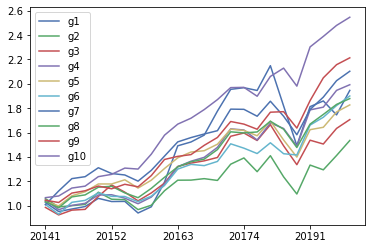

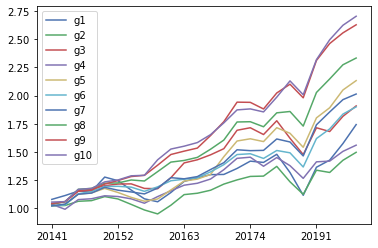

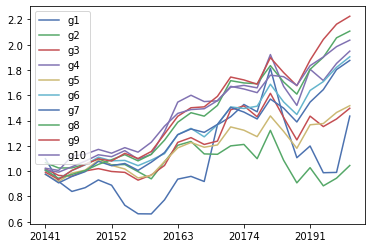

In [0]:
return_df1 = factor_backtest(spy_400_1,  'std_seasonly')
return_df2 = factor_backtest(spy_500_1, 'std_seasonly')
return_df3 = factor_backtest(spy_600_1, 'std_seasonly')

(return_df1 + 1.0).cumprod().plot()
(return_df2 + 1.0).cumprod().plot()
(return_df3 + 1.0).cumprod().plot()

In [0]:
def optimization(df, factor='std_monthly',s = 6):
    if factor == 'std_monthly':
        df2 = df[['year', 'month', 'TICKER', 'std_monthly', 'return_monthly']].drop_duplicates()
        df['yearmonth'] = df.year + df.month
        volatility_sort = df2.groupby(['year', 'month'], as_index=False).apply(lambda x: x.sort_values([factor], ascending=False))
        volatility_sort.reset_index(drop=True, inplace=True)
        volatility_sort['date'] = volatility_sort.year + volatility_sort.month
        date_list = list(np.sort(volatility_sort.date.unique()))
    elif factor == 'std_seasonly':
        df2 = df[['year', 'season', 'TICKER', 'std_seasonly', 'return_seasonly']].drop_duplicates()
        df['yearmonth'] = df.year + df.season
        volatility_sort = df2.groupby(['year', 'season'], as_index=False).apply(lambda x: x.sort_values([factor], ascending=False))
        volatility_sort.reset_index(drop=True, inplace=True)
        volatility_sort['date'] = volatility_sort.year + volatility_sort.season
        date_list = list(np.sort(volatility_sort.date.unique()))

    
    df.date = df.year+'-'+df.month+'-'+df.day
    datelist = sorted(list(df.date.unique()))
    seasonlist = list(map(lambda x:x[:4]+str((int(x[5:7])+2)//3),datelist))

    ret = {}
    w0 = {}
    w1 = {}
    turnover = {}
    temturnover = 0

    for i in range(1,len(date_list)):
        # sort from large to small (last month's vol)
        month_data = volatility_sort[volatility_sort.date==date_list[i]].sort_values(factor, ascending=False)
        month_data.reset_index(drop=True, inplace=True)

        # last month's long short list
        long = list(month_data[(month_data.index >= np.percentile(month_data.index,90))].TICKER.unique())
        short = list(month_data[(month_data.index <= np.percentile(month_data.index,10))].TICKER.unique())
        # some duplicated stocks
        duplicate_list = ['LEN', 'MKC', 'STZ', 'TAP', 'UA','BIO', 'GEF', 'WSO']
        for code in duplicate_list:
            if code in long:
                long.remove(code)
            if code in short:
                short.remove(code)

        # match the last month return
        # last month stock data
        lastmonth = df[df.yearmonth==date_list[i-1]]

        # Long stock data
        longdata = lastmonth.loc[lastmonth.TICKER.isin(long)].loc[:,['date','TICKER','PRC']]
        longdata = longdata.set_index(['date','TICKER']).drop_duplicates()
        longdata = longdata.unstack().PRC

        # short stock data
        shortdata = lastmonth.loc[lastmonth.TICKER.isin(short)].loc[:,['date','TICKER','PRC']]
        shortdata = shortdata.set_index(['date','TICKER'])
        shortdata = shortdata.unstack().PRC

        data = pd.concat([longdata, shortdata],axis=1)
        # fill na
        data = data.fillna(method = 'ffill')
        data = data.fillna(method = 'bfill')
        data = data.fillna(0)
        longlen = len(long)
        # optimization
        # Calculate expected returns and sample covariance
        mu = expected_returns.mean_historical_return(data)
        S = risk_models.sample_cov(data)
        # Optimise for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
        # Weights constraints
        ef.add_constraint(lambda x : x <= 0.03)
        ef.add_constraint(lambda x : x >= -0.03)
        # ensure the first long stock weights >= 0, short stock weights <= 0
        ef.add_constraint(lambda x : x[:longlen] >= 0)
        ef.add_constraint(lambda x : x[longlen:] <= 0)
        ef.add_constraint(lambda x : sum(x) <= s) #500-6, 400-4, 600-6
        ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=1)
        ef.efficient_risk(0.12, market_neutral = True)
        weights = ef.clean_weights()
        totol_weight = sum(map(abs,list(weights.values())))
        for w in weights:
            weights[w] /= totol_weight

        # turnover
        w1 = weights
        if len(w0) != 0:
            temturnover = 0
            for j in w1:
                temturnover += abs(w1[j] - w0.get(j,0))/2
        w0 = weights
        turnover[date_list[i]] = temturnover

        # return 
        temdata = pd.DataFrame(weights,index = ['Weight']).T
        temdata['TICKER'] = temdata.index
        start = seasonlist.index(date_list[i])
        if i != 23:
            end = seasonlist.index(date_list[i+1])
        else:
            end = len(seasonlist)
        for d in range(start,end):
            daydata = df.loc[df.date == datelist[d],['TICKER','RET']]
            if len(daydata) > 10:
                daydata = pd.merge(temdata,daydata,on=['TICKER'])
                daydata['ret'] = daydata.Weight * daydata['RET']
                ret[datelist[d]] = sum(daydata['ret'])
        
        print(date_list[i],'done',' turnover is:', temturnover)
    return ret,turnover

In [0]:
ret400,turnover400 = optimization(spy_400_1, 'std_seasonly',4)
ret500,turnover500 = optimization(spy_500_1, 'std_seasonly',6)
ret600,turnover600 = optimization(spy_600_1, 'std_seasonly',6)

/usr/local/lib/python3.6/dist-packages/pypfopt/risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."
/usr/local/lib/python3.6/dist-packages/pypfopt/risk_models.py:88: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn("Could not fix matrix. Please try a different risk model.")


20142 done  turnover is: 0
20143 done  turnover is: 0.4548437359185452
20144 done  turnover is: 0.6488720112649614
20151 done  turnover is: 0.5553515087605927
20152 done  turnover is: 0.38900255462049027
20153 done  turnover is: 0.4581440076020833
20154 done  turnover is: 0.5446639686685125
20161 done  turnover is: 0.6572503904487437
20162 done  turnover is: 0.6337630205615961
20163 done  turnover is: 0.559470292976984
20164 done  turnover is: 0.5990923209002231
20171 done  turnover is: 0.5159665072549162
20172 done  turnover is: 0.47385010299900987
20173 done  turnover is: 0.459493747568398
20174 done  turnover is: 0.5163900044622931
20181 done  turnover is: 0.6057455058160024
20182 done  turnover is: 0.5253357034536813
20183 done  turnover is: 0.6650856988383952
20184 done  turnover is: 0.5562250145432278
20191 done  turnover is: 0.5854473838306088
20192 done  turnover is: 0.5736321242429994
20193 done  turnover is: 0.5962289012416198
20194 done  turnover is: 0.5642141232331057
20142

In [0]:
def train_test_split(ret) :
    # adjusted return = return - turnover * transaction cost
    tc = 0.003
    r = pd.DataFrame(ret,index= ['Return']).T
    r['date'] = r.index
    temturnover = [0]*len(r)
    monthlist = list(r.date.apply(lambda x:x[:4]+str((int(x[5:7])+2)//3)))
    for i in turnover:
        temturnover[monthlist.index(i)] = turnover[i]
    r['Turnover'] = temturnover
    r['Adj_ret'] = r.Return - r.Turnover*tc
    r['Cum_ret'] = ((r.Return+1).cumprod()-1)*2+1
    r.index = pd.to_datetime(r.date)

    bt = r.loc[r.date < '2019']
    pt = r.loc[r.date >= '2019']
    temturnover = list(pt.Turnover)
    temturnover[0] = 0
    pt['Turnover'] = temturnover
    pt['Adj_ret'] = pt.Return - pt.Turnover*tc
    pt['Cum_ret'] = ((pt.Return+1).cumprod()-1)*2+1

    fig = plt.figure(figsize=(10,4))
    plt.plot(bt.Cum_ret, label = 'Adjusted Return')
    plt.xlabel("date")
    plt.legend()
    plt.ylabel("return")
    plt.show()

    fig = plt.figure(figsize=(10,4))
    plt.plot(pt.Cum_ret, label = 'Adjusted Return')
    plt.xlabel("date")
    plt.legend()
    plt.ylabel("return")
    plt.show()
    return bt,pt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

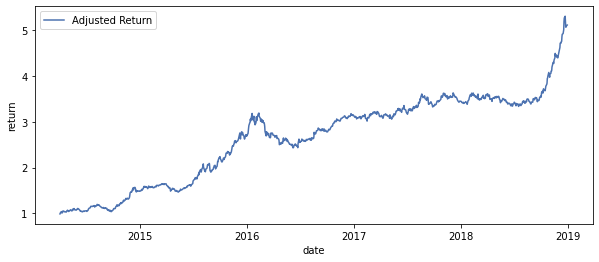

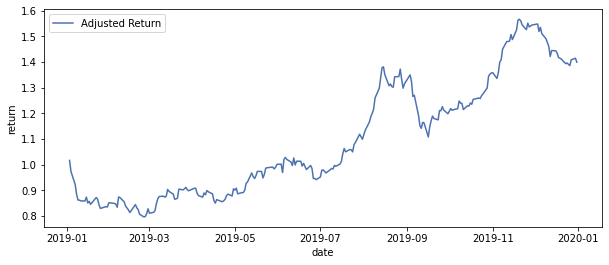

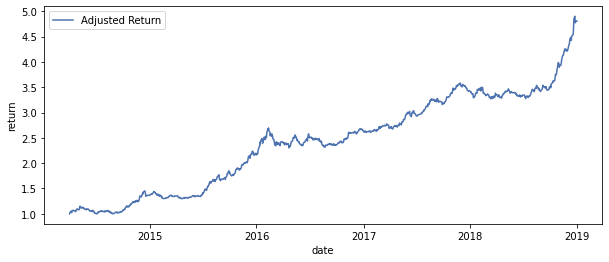

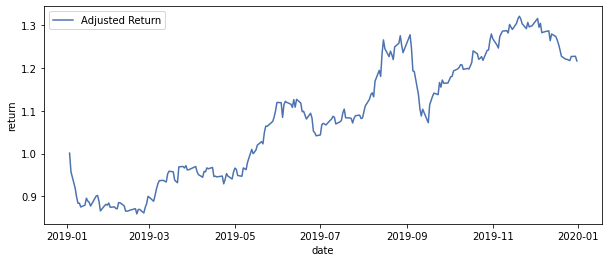

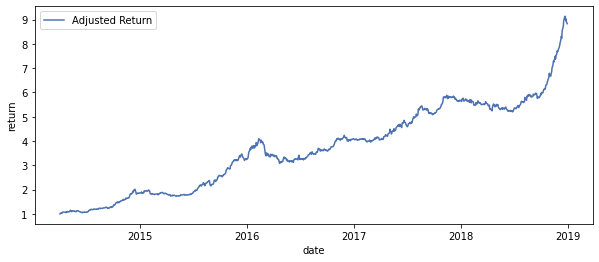

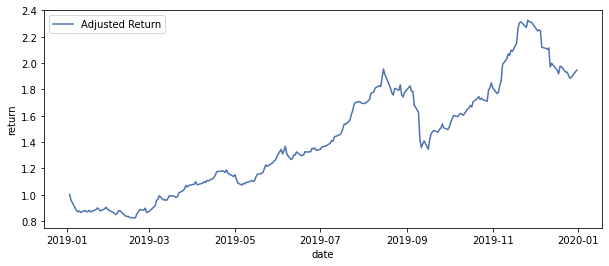

In [0]:
train400,test400 = train_test_split(ret400)
train500,test500 =train_test_split(ret500)
train600,test600 =train_test_split(ret600)

In [0]:
def risk_matrics(ret,rf = 0.58/100):
    # Integrated daily return
    # ? monthly return ?  
    daily_return = pd.DataFrame(ret).copy()
    df_whole = daily_return

    ### Compute performance stat
    ## Return related
    # Cumulative Return
    cumulative_return = (df_whole + 1).cumprod()
    fig = plt.figure(figsize=[10, 5])
    ax1 = fig.add_subplot(121)
    ax1.plot(cumulative_return)
    ax1.set_title("Cumulative Return",fontsize=20)

    # Return Distribution
    ax2 = fig.add_subplot(122)
    # daily_return.hist(ax = ax2)
    sns.distplot(daily_return,color='cornflowerblue',ax = ax2)
    ax2.set_title("Return Distribution",fontsize=20)

    plt.tight_layout(pad=3,h_pad=1,w_pad=0.5)
    plt.subplots_adjust(hspace=0.25)
    # Annualized Return
    # ax2 = fig.add_subplot(222)
    Annualized_return = pow(cumulative_return.iloc[-1,:],252/len(df_whole)) - 1
    
    # Annualized_return.plot(kind='bar',ax=ax2,rot=45)
    # ax2.set_title("Annualized Return",fontsize=20)

    # Annualized Volatility
    # ax3 = fig.add_subplot(223)
    Annualized_vol = df_whole.std() * np.sqrt(252)
    
    # Annualized_vol.plot(kind='bar',ax=ax3,rot=45)
    # ax3.set_title("Annualized Volatility",fontsize=20)

    # Info ratio -- Here is defined as Return/vol
    # ax4 = fig.add_subplot(224)
    Information_ratio = Annualized_return / Annualized_vol
    # Information_ratio.plot(kind='bar',ax=ax4,rot=45)
    # ax4.set_title("Information Ratio",fontsize=20)
    

    ## Drawdown - related        
    running_max = np.maximum.accumulate(cumulative_return)
    running_max[running_max < 0] = 0
    drawdown = (cumulative_return - running_max)/running_max 

    ## plot DD curve
    fig2 = plt.figure()
    drawdown.plot()
    for strat in drawdown.columns:
      plt.fill_between(drawdown.index,drawdown[strat],color='grey',alpha=0.2)
    plt.title("Drawdown Curve",fontsize=20)
    plt.tight_layout()
      
    fig3 = plt.figure()
    cumulative_return.plot()
    for strat in drawdown.columns:
      plt.fill_between(drawdown.index,drawdown[strat],color='grey',alpha=0.2)
    plt.title("Cumulative Return & Drawdown",fontsize=20)
    plt.legend(loc='upper left')
    plt.tight_layout()
      
    # Largest 3 DD    
    dd_dic = dict.fromkeys(df_whole.columns,[])
    for colname, col in drawdown.items():
      drawdown_count = []
      tmp = []
      day_fall = 0
      day_recover = 0
      for i in range(len(col)):
          if col[i] < 0:
              tmp.append(col[i])
          if (col[i] == 0) or (i == (len(col) - 1)):
              if (len(tmp) != 0):
                  day_fall = tmp.index(min(tmp)) + 1
                  day_recover = len(tmp) + 1 - day_fall
                  drawdown_count.append([min(tmp),day_fall,day_recover])
              tmp.clear()
      drawdown_count.sort(key=lambda x:x[0])
      dd_dic[colname] = list(itertools.chain.from_iterable(drawdown_count[:3])) ## make it falt
      
    Mdd = pd.DataFrame(dd_dic).T
    Mdd.columns = ['MDD','drough1','recover1','2DD','drough2','recover2','3DD','drough3','recover3']

    ### Other ratio
    # win, lose ratio
    win_ratio = df_whole[df_whole > 0].count() / len(df_whole)
    win_ratio =win_ratio[0]
    # win_ratio = df_whole[df_whole > 0].count() / len(df_whole[df_whole != 0].dropna())
    lose_ratio = df_whole[df_whole < 0].count() / len(df_whole)
    lose_ratio = lose_ratio[0] 
    # median daily return, average daily return
    median_return = df_whole.median()[0]
    average_return = df_whole.mean()[0]


    # Sortino Ratio
    ret_new = df_whole.where(df_whole>0)
    exc_ret = Annualized_return - rf
    std = np.array(ret_new.std())*np.sqrt(252)
    sortino = (exc_ret / std)[0]

    # Calman Ratio
    calmar = Annualized_return / drawdown_count[0][0]
    calmar = calmar[0]


    Annualized_return = Annualized_return[0]
    Annualized_vol = Annualized_vol[0]
    Information_ratio = Annualized_return / Annualized_vol

    
    Result1 = pd.DataFrame([Annualized_return,median_return,average_return,Annualized_vol]).T
    Result1.columns = ["Annualized_return","median_return","average_return","Annualized_vol"]
    Result1.index = ["Result"]

    Result2 = pd.DataFrame([Information_ratio,calmar,sortino,win_ratio,lose_ratio]).T
    Result2.columns = ["Information_ratio","calmar","sortino","win_ratio","lose_ratio"]
    Result2.index = ["Result"]

    Result3 = Mdd
    Result3.index = ["Result"]

    skew = stats.skew(df_whole)
    kurtosis = stats.kurtosis(df_whole)

    print("Return 's Skewness:",skew)  
    print("Return 's Kurtosis:",kurtosis)  
    return Result1,Result2,Result3
    

Return 's Skewness: [0.05835504]
Return 's Kurtosis: [2.13616942]


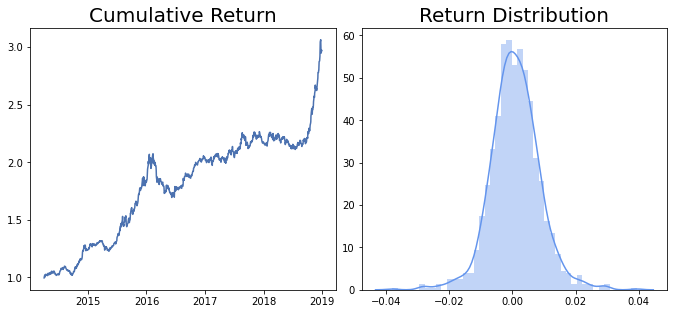

<Figure size 432x288 with 0 Axes>

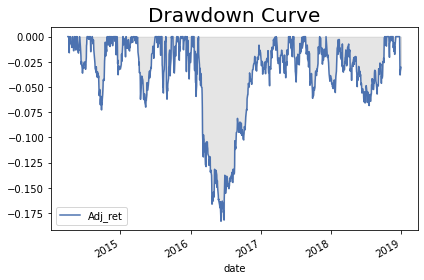

<Figure size 432x288 with 0 Axes>

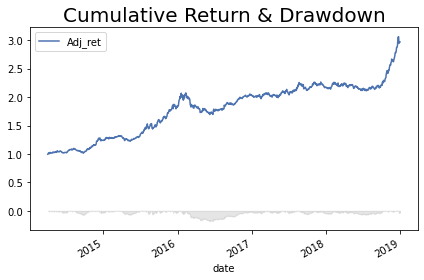

In [0]:
r41,r42,r43 = risk_matrics(train400.Adj_ret)

In [0]:
r41

,Annualized_return,median_return,average_return,Annualized_vol
Result,0.26226,0.000717,0.000955,0.123859


In [0]:
r42

,Information_ratio,calmar,sortino,win_ratio,lose_ratio
Result,2.117405,-1.432535,3.011117,0.539049,0.460951


In [0]:
r43

,MDD,drough1,recover1,2DD,drough2,recover2,3DD,drough3,recover3
Result,-0.183074,79.0,195.0,-0.072629,33.0,23.0,-0.069892,32.0,35.0


Return 's Skewness: [0.25265855]
Return 's Kurtosis: [1.78088886]


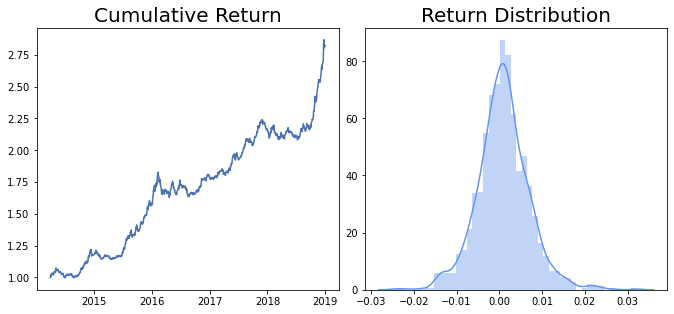

<Figure size 432x288 with 0 Axes>

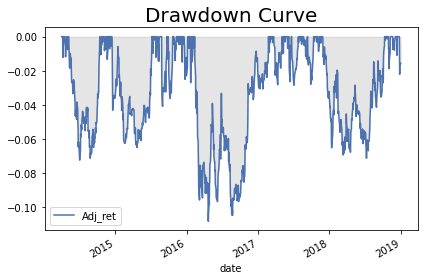

<Figure size 432x288 with 0 Axes>

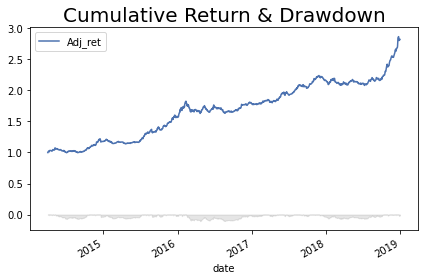

In [0]:
r51,r52,r53 = risk_matrics(train500.Adj_ret)

In [0]:
r51

,Annualized_return,median_return,average_return,Annualized_vol
Result,0.248569,0.000771,0.0009,0.096962


In [0]:
r52

,Information_ratio,calmar,sortino,win_ratio,lose_ratio
Result,2.563586,-2.297419,3.50507,0.567912,0.432088


In [0]:
r53

,MDD,drough1,recover1,2DD,drough2,recover2,3DD,drough3,recover3
Result,-0.108195,47.0,212.0,-0.072366,39.0,70.0,-0.071247,150.0,65.0


Return 's Skewness: [0.15375254]
Return 's Kurtosis: [1.1095328]


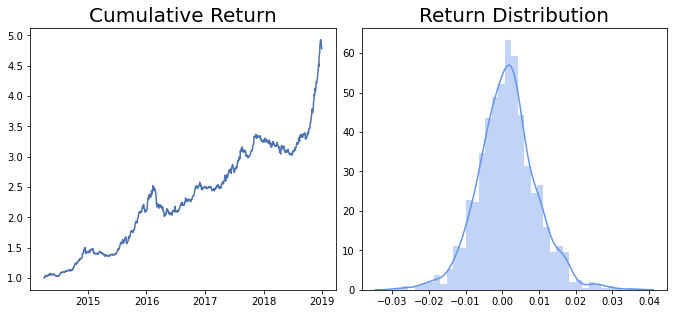

<Figure size 432x288 with 0 Axes>

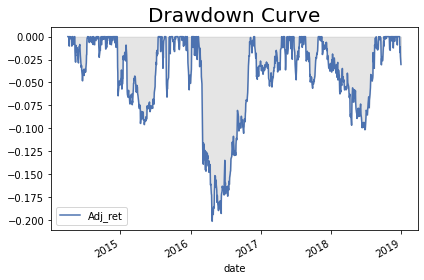

<Figure size 432x288 with 0 Axes>

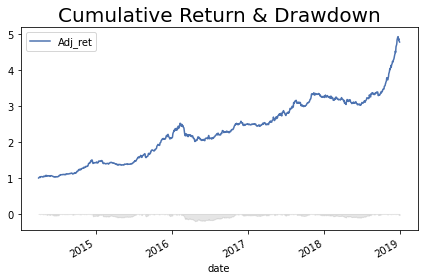

In [0]:
r61,r62,r63 = risk_matrics(train600.Adj_ret)

In [0]:
r61

,Annualized_return,median_return,average_return,Annualized_vol
Result,0.397202,0.001266,0.00136,0.127505


In [0]:
r62

,Information_ratio,calmar,sortino,win_ratio,lose_ratio
Result,3.115195,-1.972528,4.412054,0.570458,0.429542


In [0]:
r63

,MDD,drough1,recover1,2DD,drough2,recover2,3DD,drough3,recover3
Result,-0.201367,48.0,150.0,-0.101557,150.0,49.0,-0.095991,94.0,51.0


**Backtest**

Return 's Skewness: [-0.13124086]
Return 's Kurtosis: [1.35421812]


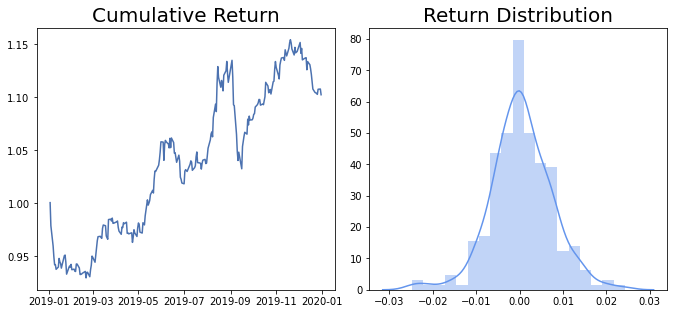

<Figure size 432x288 with 0 Axes>

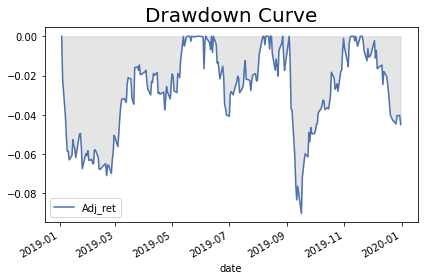

<Figure size 432x288 with 0 Axes>

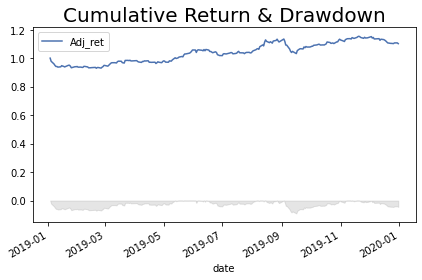

In [0]:
r1,r2,r3 = risk_matrics(test500.Adj_ret)

In [0]:
r1

,Annualized_return,median_return,average_return,Annualized_vol
Result,0.104134,0.000271,0.000419,0.113353


In [0]:
r2

,Information_ratio,calmar,sortino,win_ratio,lose_ratio
Result,0.918672,-1.153575,1.302343,0.528226,0.471774


In [0]:
r3

,MDD,drough1,recover1,2DD,drough2,recover2,3DD,drough3,recover3
Result,-0.090271,9.0,39.0,-0.071017,32.0,56.0,-0.045005,26.0,1.0


Return 's Skewness: [-0.22300371]
Return 's Kurtosis: [0.56210237]


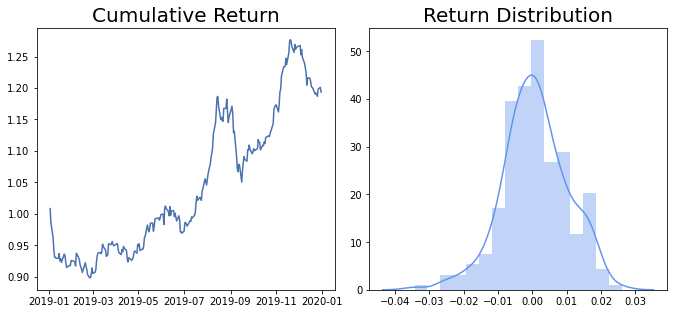

<Figure size 432x288 with 0 Axes>

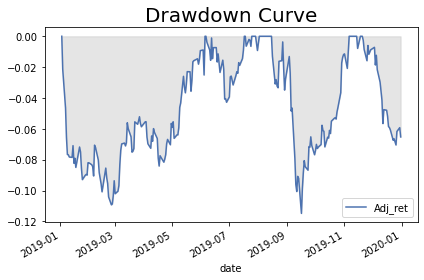

<Figure size 432x288 with 0 Axes>

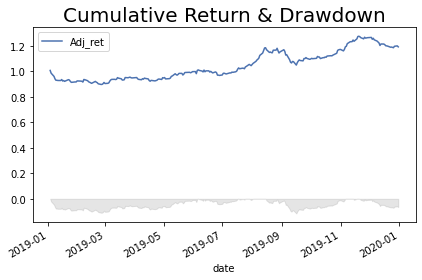

In [0]:
r1,r2,r3 = risk_matrics(test400.Adj_ret)

In [0]:
r1

,Annualized_return,median_return,average_return,Annualized_vol
Result,0.196816,0.000461,0.000758,0.150976


In [0]:
r2

,Information_ratio,calmar,sortino,win_ratio,lose_ratio
Result,1.303624,-1.714313,1.998226,0.532258,0.467742


In [0]:
r3

,MDD,drough1,recover1,2DD,drough2,recover2,3DD,drough3,recover3
Result,-0.114808,21.0,37.0,-0.109263,35.0,69.0,-0.070464,23.0,4.0


Return 's Skewness: [-1.25141601]
Return 's Kurtosis: [6.04873359]


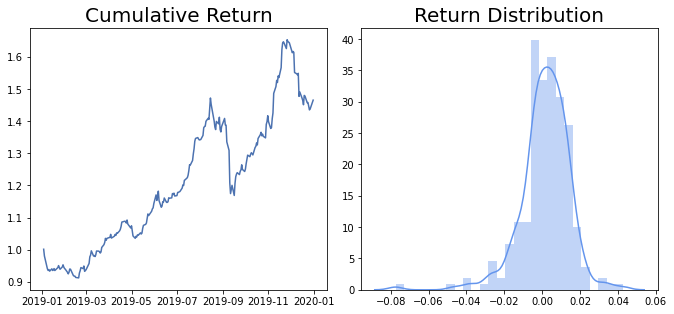

<Figure size 432x288 with 0 Axes>

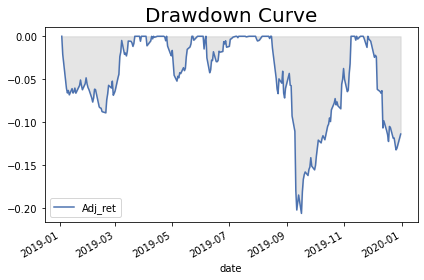

<Figure size 432x288 with 0 Axes>

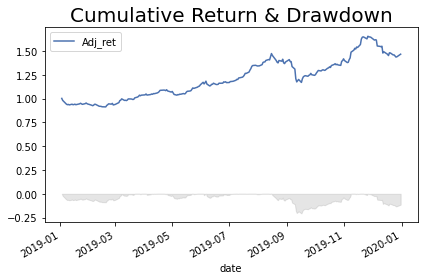

In [0]:
r1,r2,r3 = risk_matrics(test600.Adj_ret)

In [0]:
r1

,Annualized_return,median_return,average_return,Annualized_vol
Result,0.474866,0.002658,0.001629,0.206879


In [0]:
r2

,Information_ratio,calmar,sortino,win_ratio,lose_ratio
Result,2.295383,-2.304079,4.166346,0.584677,0.415323


In [0]:
r3

,MDD,drough1,recover1,2DD,drough2,recover2,3DD,drough3,recover3
Result,-0.206098,21.0,39.0,-0.132151,19.0,4.0,-0.089074,31.0,23.0


--------------- finished

In [0]:
def ADV(df):
    df['year'] = df['date'].apply(lambda x:x[-4:])
    df = df.loc[df.year == '2013']
    ADV = df.groupby(['TICKER']).PRC.mean()*df.groupby(['TICKER']).VOL.mean()
    ADV = dict(ADV)
    ADV = list(sorted(ADV.items(), key = lambda x:x[1]))
    output = []
    for i in ADV:
        if i[1] < 1000000:
            output.append(i[0])
        else:
            break
    return output